# Features engineering

In [1]:
#!pip install holidays

In [2]:
#Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#### Obtención de variables temporales

Con el objtivo de analizar variables temporales como, día de la semana, si es fin de semana, si es un día de fiesta, la temporada del año que es, y el tiempo en el día que se está analizando, se realiza la implementación de estas funciones.

In [3]:
#Loading Dataset preprocessed

dataPath = "../data/processed/pro_household_power_consumption.csv"

dataset = pd.read_csv(dataPath, index_col=0, parse_dates=True)
dataset.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,unmeasured
Datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [8]:
def plot_pattern_by_filter(df, column_filter, filter_value, variable='Global_active_power'):
    """
    Filtra el DataFrame por un valor específico en una columna y genera un gráfico de línea para la variable seleccionada.
    
    Parámetros:
    - df: DataFrame con índice datetime y columnas como 'day_of_week', 'season', 'is_holiday', etc.
    - column_filter: str, nombre de la columna para filtrar (ej. 'day_of_week')
    - filter_value: valor para aplicar el filtro (ej. 0 para lunes)
    - variable: str, nombre de la variable a graficar (por defecto 'Global_active_power')
    """
    # Filtrado
    df_filtered = df[df[column_filter] == filter_value]
    
    # Agrupación por hora del día si existe la columna correspondiente
    if 'hour' in df_filtered.columns:
        grouped = df_filtered.groupby('hour')[variable].mean()
        x_label = 'Hour of Day'
    else:
        grouped = df_filtered[variable]
        x_label = column_filter
    
    # Gráfico
    plt.figure(figsize=(10, 5))
    #plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='steelblue')
    plt.plot(grouped.index, grouped.values, color='steelblue')
    plt.title(f'{variable} Pattern - {column_filter} = {filter_value}')
    plt.xlabel(x_label)
    plt.ylabel(variable)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

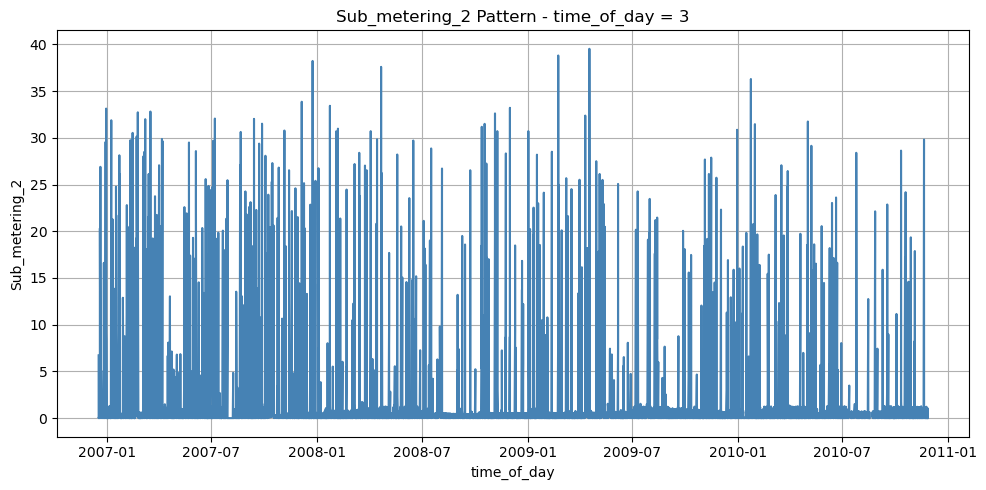

In [9]:
plot_pattern_by_filter(dtemp_rhm, column_filter ='time_of_day', filter_value = 3, variable= 'Sub_metering_2')

### Transformación de los datos para realizar feature engineering

In [10]:
def clean_and_log_transform(X):
    X = X.copy()
    # Reemplaza valores negativos con cero si lo consideras apropiado
    X[X < 0] = 0
    
    # Aplicamos log1p y manejamos valores infinitos
    X_log = np.log1p(X)
    X_log = np.where(np.isfinite(X_log), X_log, 0)  # reemplaza inf o nan con 0
    return X_log

def build_statistical_pipeline():
    # Transformación logarítmica segura (log1p = log(1+x))
    log_transform = FunctionTransformer(clean_and_log_transform, validate=False)

    # Normalización (Z-score)
    scaler = StandardScaler()

    # Construcción del pipeline
    pipeline = Pipeline([
        ('log_transform', log_transform),
        ('scaler', scaler)
    ])
    return pipeline

In [ ]:
features = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

In [12]:
pipeline = build_statistical_pipeline()
X = dtemp_rhm[features].copy()
X_transformed = pipeline.fit_transform(X)

# Crear DataFrame transformado
df_rhm_transformed = pd.DataFrame(
    X_transformed,
    index=dtemp_rhm.index,
    columns=[f"{col}_scaled" for col in features]
)

# Normalización (Z-score)
scaler = StandardScaler()
df_rhm_scaled = scaler.fit_transform(dtemp_rhm)

In [13]:
df_rhm_transformed.head(10)

,Global_active_power_scaled,Global_reactive_power_scaled,Voltage_scaled,Global_intensity_scaled,Sub_metering_1_scaled,Sub_metering_2_scaled,Sub_metering_3_scaled
Datetime,,,,,,,
2006-12-16 17:00:00,2.561101,1.602495,0.067991,2.233582,-0.366222,0.003340,1.296467
2006-12-16 18:00:00,2.254498,-0.633315,0.067542,2.016211,-0.366222,2.526417,1.296736
2006-12-16 19:00:00,2.123257,-0.550202,0.058010,1.910307,-0.366222,0.728448,1.287797
2006-12-16 20:00:00,2.045649,-0.712535,0.063951,1.850534,-0.366222,-0.656907,1.292684
2006-12-16 21:00:00,1.915450,-0.687338,0.085627,1.757419,-0.366222,-0.114290,1.313551
2006-12-16 22:00:00,1.309700,-1.019984,0.096760,1.309942,-0.366222,-0.461919,0.265001
2006-12-16 23:00:00,1.196646,-0.771652,0.109597,1.214808,-0.366222,-0.532211,-1.201977
2006-12-17 00:00:00,1.042624,-0.278102,0.111948,1.089303,-0.366222,-0.060255,-1.201977
2006-12-17 01:00:00,2.093573,0.255111,0.108418,1.884439,-0.366222,4.432703,-1.201977


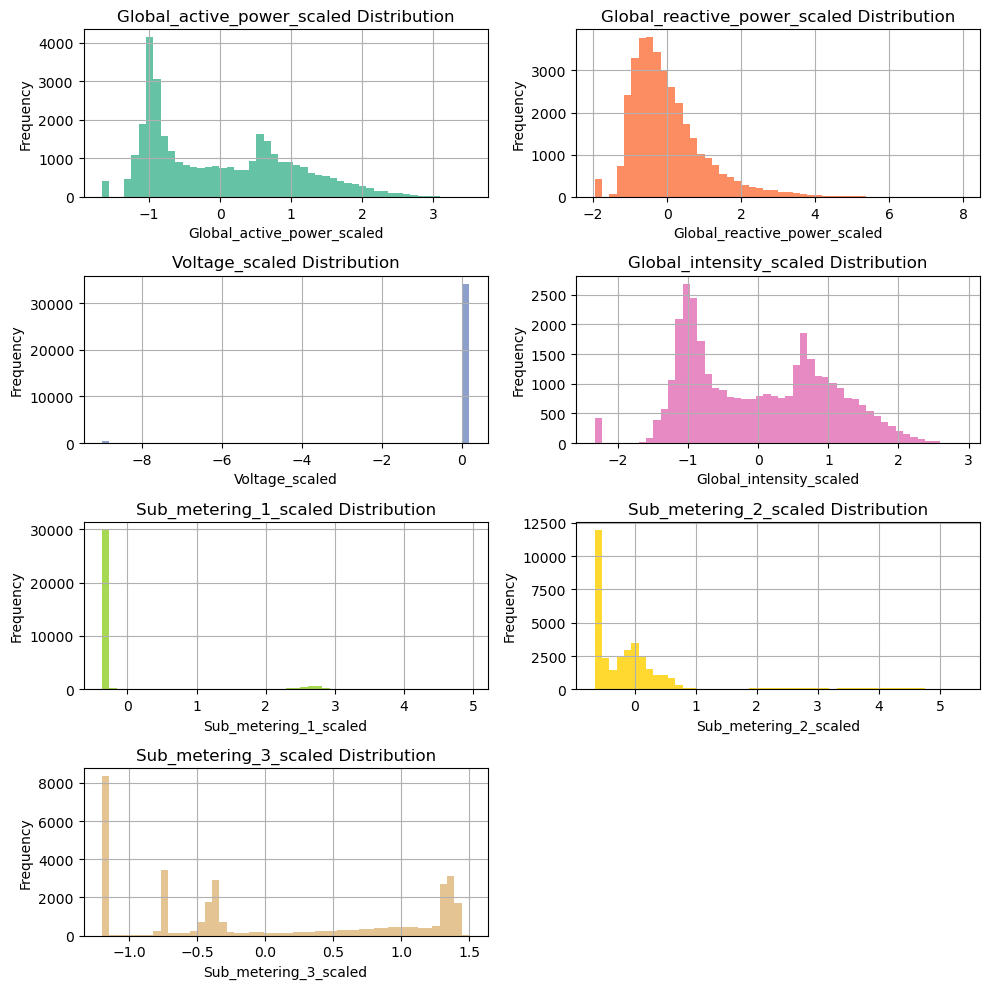

In [14]:
colors = sns.color_palette("Set2", len(df_rhm_transformed.columns))

plots_per_row = 2

num_rows = len(df_rhm_transformed.columns) // plots_per_row + (len(df_rhm_transformed.columns) % plots_per_row > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(10, 10))

axes = axes.flatten()

for i, (col, color) in enumerate(zip(df_rhm_transformed.columns, colors)):
    df_rhm_transformed[col].hist(bins=50, ax=axes[i], color=color)
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()